# Bump Hunt with baseline features and BDT setup

For these plots, a bump hunt is performed with the original LHCO R&D dataset only. Sliding windows are all 0.4TeV wide and move by 0.1TeV. These runs use k-fold cross validation at k=5. 

The systematics are estimated as 
\begin{equation}
    \mathcal{S}= \frac{N'-\varepsilon_B (1+\alpha) N_{SR}}{\sqrt{\sigma_{stat}^2+\sigma_{sys}^2}}
\end{equation}
where $\alpha$ is a relative systematic offset caused by the systematic differences between CR and SR bkg.

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
BH_percentiles = [1e-2, 1e-3, 1e-4]
general_directory = "/hpcwork/zu992399/bumphunt_paper/"
plotting_direc = "plots/"

In [31]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
#plt.rcParams['text.usetex'] = True
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = True

In [32]:
def calc_and_apply_threshold(samples_preds, data_preds, labels, efficiency):
    eps = np.quantile(samples_preds, 1-efficiency)
    if efficiency == 1:
        eps=0.
    N_samples_after = np.size(np.where(samples_preds>eps))
    N_samples = len(samples_preds)
    N_after = np.size(np.where(data_preds>eps))
    N = len(data_preds)
    N_bkg = np.size(np.where(data_preds[labels==0]>eps))
    N_sig = np.size(np.where(data_preds[labels==1]>eps))
    return N_samples_after, N_samples, N_after, N, N_bkg, N_sig

def significances(N_after, N, N_sig, N_bkg, eff, err, cwola):
    if cwola: 
        results = (N_after-N*eff)/np.sqrt(eff*N*2)
        rel_results = (N_after-(1+err)*N*eff)/np.sqrt(eff*N*2+(eff*err*N)**2)
        true_results = N_sig/np.sqrt(N_bkg*2)
    else: 
        results = (N_after-N*eff)/np.sqrt(eff*N)
        rel_results = (N_after-(1+err)*N*eff)/np.sqrt(eff*N+(eff*err*N)**2)
        true_results = N_sig/np.sqrt(N_bkg)
    rel_error = (N_after-N*eff)/(eff*N)
    return results, rel_results, true_results, rel_error

In [33]:
def bump_hunt_single_window(folder, cwola, window, err=None, runs=10):
	results = np.zeros((len(BH_percentiles),runs))
	true_results =  np.zeros((len(BH_percentiles),runs))
	rel_results =  np.zeros((len(BH_percentiles),runs))
	rel_error =  np.zeros((len(BH_percentiles),runs))

	arr_shape = (5,len(BH_percentiles), runs)
	N_samples_after = np.zeros(arr_shape)
	N_samples = np.zeros(arr_shape)
	N_after = np.zeros(arr_shape)
	N = np.zeros(arr_shape)
	N_bkg = np.zeros(arr_shape)
	N_sig = np.zeros(arr_shape)
	N_bkg_orig = 0

	for fold in range(5): 
		f = folder +"fold"+str(fold)+"/"
		samples_preds = np.load(f+"samples_preds.npy")
		data_preds = np.load(f+"test_preds.npy")
		labels = np.load(f+"Y_test.npy")
		N_bkg_orig += np.shape(data_preds[:,labels==0])[-1]
		for j, perc in enumerate(BH_percentiles):
			for i in range(len(samples_preds)):
				N_samples_after[fold, j, i], N_samples[fold, j, i], N_after[fold, j, i], N[fold, j, i], N_bkg[fold, j, i], N_sig[fold, j, i] = calc_and_apply_threshold(samples_preds[i], data_preds[i], labels, perc)
	N_samples_after = np.sum(N_samples_after, axis=0)
	N_samples = np.sum(N_samples, axis=0)
	N_after = np.sum(N_after, axis=0)
	N = np.sum(N, axis=0)
	N_bkg = np.sum(N_bkg, axis=0)
	N_sig = np.sum(N_sig, axis=0)
	eff_eff = N_samples_after/N_samples

	if err is None:
		err = np.zeros(len(BH_percentiles))
		
	for j, perc in enumerate(BH_percentiles):
		results[j], rel_results[j], true_results[j], rel_error[j] = significances(N_after[j], N[j], N_sig[j], N_bkg[j], eff_eff[j], err[j], cwola)

	return results, rel_results, true_results, rel_error

def bump_hunt(folder, cwola, err=None, runs=10):
	print(folder)

	results = np.zeros((len(BH_percentiles),9,runs))
	true_results =  np.zeros((len(BH_percentiles),9,runs))
	rel_results =  np.zeros((len(BH_percentiles),9,runs))
	rel_error =  np.zeros((len(BH_percentiles),9,runs))

	for window in range(9):
		results[:,window], rel_results[:,window], true_results[:,window], rel_error[:,window] = bump_hunt_single_window(folder+"window"+str(window+1)+"_", cwola, window, err=err, runs=runs)
	
	return results, rel_results, true_results, rel_error

In [34]:
colors_results = ["blue", "red", "orange"]
#colors_true = ["dodgerblue", "orange", "lilac"]

def plotting(rel_results, true_results, name):
    plt.figure()
    x = range(1,10)
    plt.axhline(5, color="black", linestyle="--", label="5$\sigma$")
    plt.axhline(0, color="black", label="0$\sigma$")
    for j, perc in enumerate(BH_percentiles):
        plt.errorbar(x, np.mean(rel_results[j],axis=-1), yerr = np.std(rel_results[j], axis=-1,ddof=1), label=r"$\epsilon_B$="+str(perc), fmt='o', color=colors_results[j])
        #plt.errorbar(x, np.mean(true_results[j],axis=-1), yerr = np.std(rel_results[j], axis=-1,ddof=1), fmt='o', color=colors_true[j])
        
    plt.grid()
    plt.ylabel(r"Significance")
    plt.xlabel(r"Sliding window #")
    plt.legend()
    plt.subplots_adjust(bottom=0.15, left= 0.19, top = 0.92, right = 0.965)

    plt.savefig(plotting_direc+name+".pdf")
    plt.savefig(plotting_direc+name+".png")


## CWoLa

First, the systematic offset is determined as a constant relative offset in $m_{JJ}$ with 
\begin{equation}
    \alpha = \frac{N'-\varepsilon_B N_{SR}}{\varepsilon_B N_{SR}}
\end{equation}
based on 10 runs without signal.

We estimate our systematic error conservatively with $\sigma_{sys}=\alpha\varepsilon_B N_{SR}.$ 

/hpcwork/zu992399/bumphunt_paper/cwola_without/


/hpcwork/zu992399/bumphunt_paper/cwola_without/
alpha = [0.13928276 0.18179787 0.44541193]


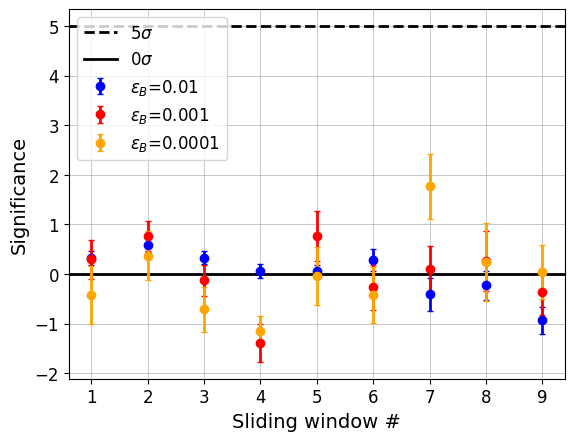

In [35]:
folder = general_directory+"cwola_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
cwola_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cwola_without")
print("alpha =",cwola_error)

We test our systematic error by considering 100 independent runs (on the same dataset).

/hpcwork/zu992399/bumphunt_paper/cwola_without_fluctuations/


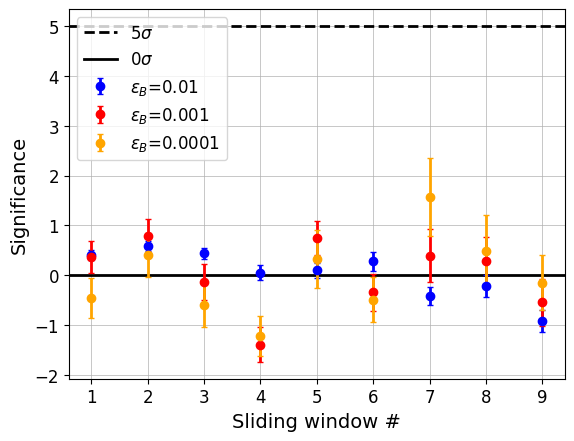

In [36]:
folder = general_directory+"cwola_without_fluctuations/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=cwola_error, runs=100)
plotting(rel_results, true_results, "cwola_without_fluct")

In [37]:
print("Max Abweichung:",np.max(rel_results))
chi2 = np.sum(rel_results**2, axis=(1,2))
N_data = len(rel_results[1,1])*len(rel_results[1])
print("chi^2=", chi2)
print("DOF= ",N_data)

Max Abweichung: 3.8261735372834713
chi^2= [209.45647662 534.51640686 792.84643284]
DOF=  900


Results show a good agreement with the null hypothesis with a slightly overestimated error that is in the correct order of magnitude.

We now look at an analysis with signal: 

/hpcwork/zu992399/bumphunt_paper/cwola_norm/


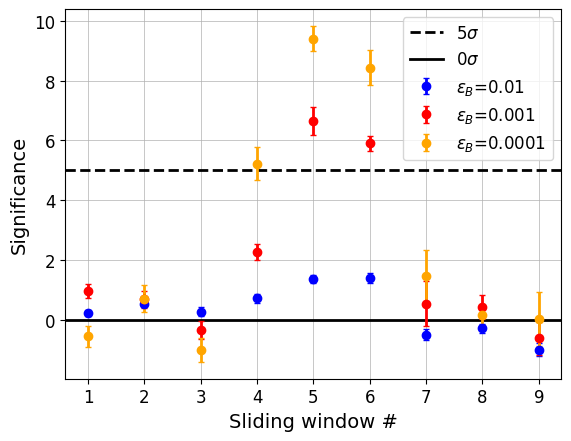

In [38]:
folder = general_directory+"cwola_norm/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=cwola_error)
plotting(rel_results, true_results, "cwola_norm")

## CATHODE

We now perform the same analysis for CATHODE. We do not rerun the DE for different runs. First 10 runs without signal to estimate the systematic offset and error.

/hpcwork/zu992399/bumphunt_paper/cathode_without/
/hpcwork/zu992399/bumphunt_paper/cathode_without/
alpha =  [0.20820882 0.40623955 0.9520765 ]


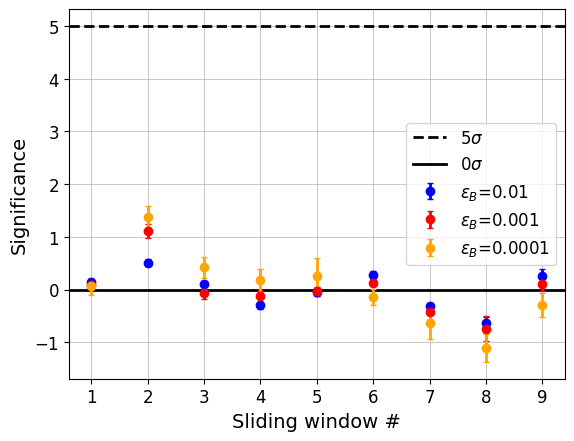

In [39]:
folder = general_directory+"cathode_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
cathode_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=cathode_error)
plotting(rel_results, true_results, "cathode_without")
print("alpha = ", cathode_error)

We test the systematic error on 100 independent runs.

/hpcwork/zu992399/bumphunt_paper/cathode_without_fluctuations/


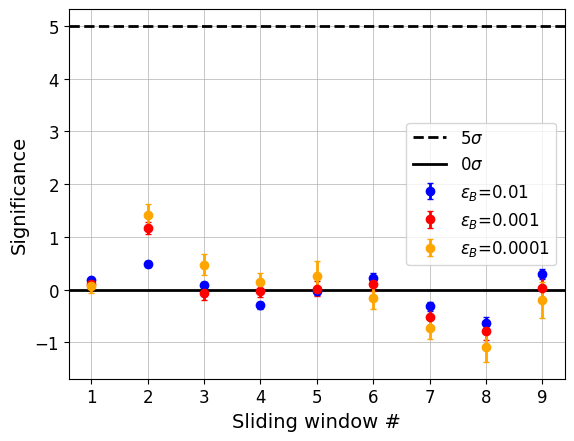

In [40]:
folder = general_directory+"cathode_without_fluctuations/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=cathode_error, runs=100)
plotting(rel_results, true_results, "cathode_without_fluct")

In [41]:
print("Max Abweichung:",np.max(rel_results))
chi2 = np.sum(rel_results**2, axis=(1,2))
N_data = len(rel_results[1,1])*len(rel_results[1])
print("chi^2=", chi2)
print("DOF= ",N_data)

Max Abweichung: 1.914111087579969
chi^2= [105.03065552 246.1087454  457.59584623]
DOF=  900


We find that the error is further overestimated than for CWoLa. The density estimation should be improved. Especially window 2 has a large systematic offset compared to the other SR windows.
 
In the results with signal, we see the effect of the large systematic error from the "bad" DE. As this also affects the achieved SIC, the quality of the DE is crucial.

/hpcwork/zu992399/bumphunt_paper/cathode_norm/


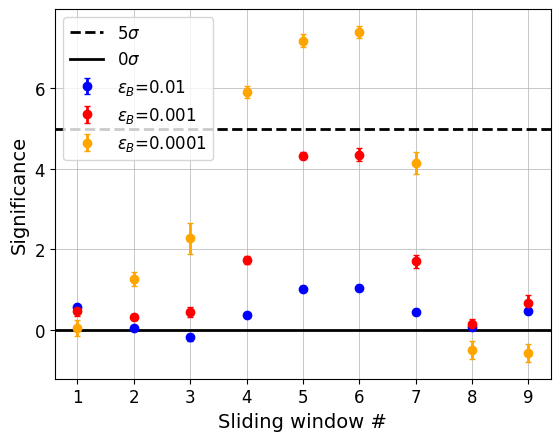

In [42]:
folder = general_directory+"cathode_norm/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=cathode_error)
plotting(rel_results, true_results, "cathode_norm")

## IAD 

As a furhter test of the method and the classifier we also take a look at the IAD. 100 runs in the true SR but without signal should not show any significant systematic offset.

In [43]:
folder = general_directory+"IAD_without/"
results, rel_results, true_results, rel_error = bump_hunt_single_window(folder, True, 4, err=np.array([0,0,0]), runs=100)

#plotting(rel_results, true_results, "IAD_without")

In [44]:
print("Mean:", np.mean(rel_results))
print("Std:", np.std(rel_results, ddof=1))
print("Max Abweichung:",np.max(rel_results))
print("Max Abweichung:",np.min(rel_results))
chi2 = np.sum(rel_results**2, axis=1)
N_data = len(rel_results[1])
print("chi^2=", chi2)
print("DOF= ",N_data)

Mean: 0.33027035465095184
Std: 0.7826731619871863
Max Abweichung: 2.0631544506336126
Max Abweichung: -1.614939787919725
chi^2= [115.33303291  44.54612175  56.00500376]
DOF=  100


/hpcwork/zu992399/bumphunt_paper/IAD_half_without/
/hpcwork/zu992399/bumphunt_paper/IAD_half_without/
alpha = [1.61947062e-17 0.00000000e+00 0.00000000e+00]


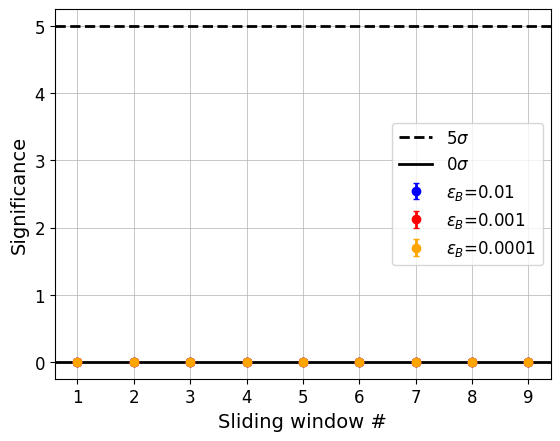

In [45]:
folder = general_directory+"IAD_half_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
IAD_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=IAD_error)
plotting(rel_results, true_results, "IAD_half_without")
print("alpha =", IAD_error)

/hpcwork/zu992399/bumphunt_paper/IAD_half_without/


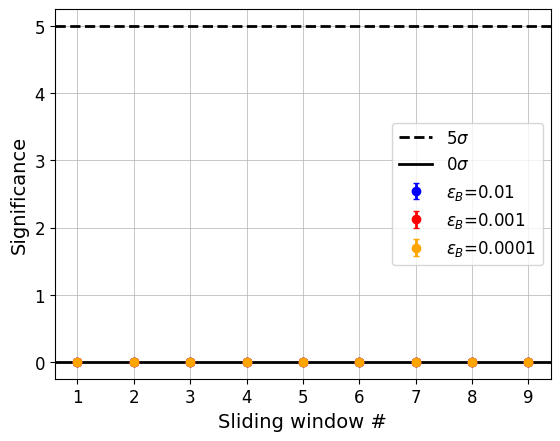

In [51]:
folder = general_directory+"IAD_half_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=[0,0,0])
plotting(rel_results, true_results, "IAD_half_without")

/hpcwork/zu992399/bumphunt_paper/IAD_half_norm/


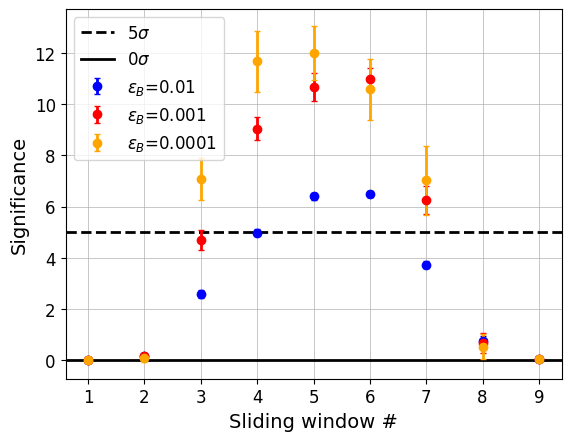

In [47]:
folder = general_directory+"IAD_half_norm/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=IAD_error)
plotting(rel_results, true_results, "IAD_half_norm")

/hpcwork/zu992399/bumphunt_paper/IAD_half_without_2/
/hpcwork/zu992399/bumphunt_paper/IAD_half_without_2/
alpha = [0.0363044  0.05212781 0.37332669]


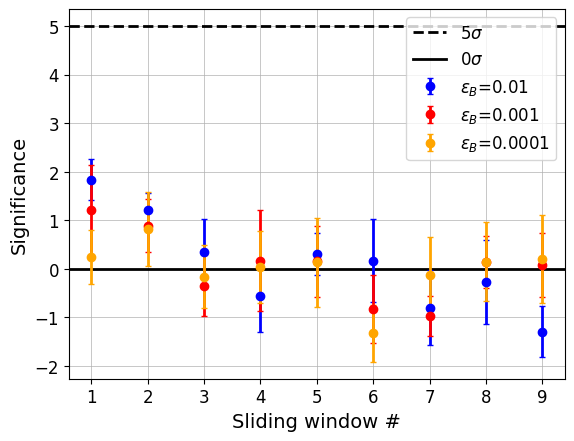

In [52]:
folder = general_directory+"IAD_half_without_2/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
IAD_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=IAD_error)
plotting(rel_results, true_results, "IAD_half_without_2")
print("alpha =", IAD_error)

/hpcwork/zu992399/bumphunt_paper/IAD_half_without_2/


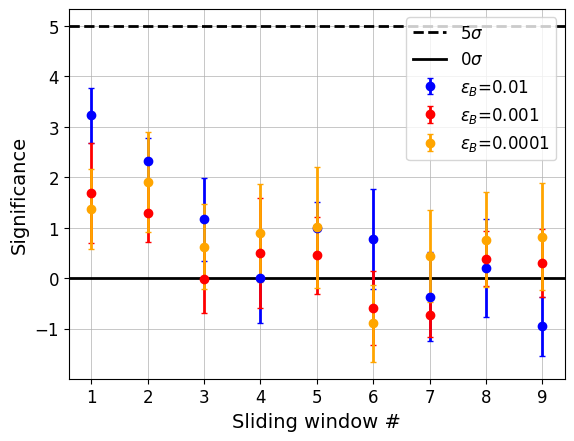

In [55]:
folder = general_directory+"IAD_half_without_2/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=[0,0,0])
#print(rel_results)
plotting(rel_results, true_results, "IAD_half_without_2")

/hpcwork/zu992399/bumphunt_paper/IAD_half_norm_2/


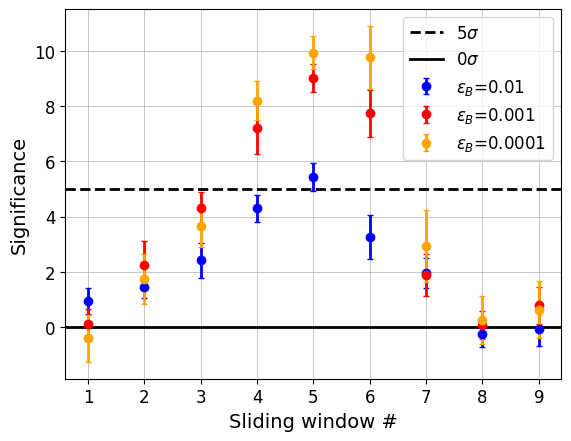

In [56]:
folder = general_directory+"IAD_half_norm_2/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=IAD_error)
plotting(rel_results, true_results, "IAD_half_norm_2")

Indeed, a good agreement with the null hypothesis is found.

# Doctor CATHODE

/hpcwork/zu992399/bumphunt_paper/cathode_without_weights/
/hpcwork/zu992399/bumphunt_paper/cathode_without_weights/
alpha =  [0.1459041  0.36143469 0.62960315]
alpha without Doctor =  [0.20820882 0.40623955 0.9520765 ]


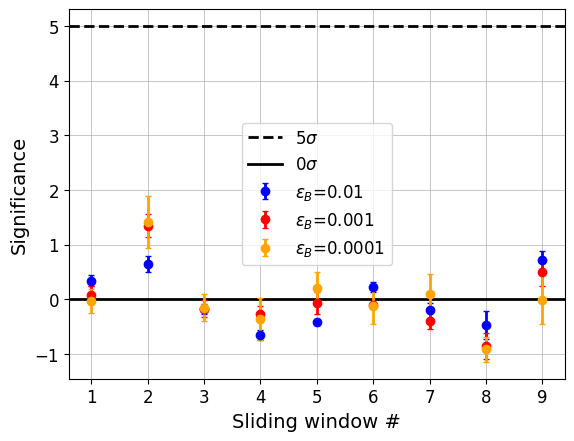

In [48]:
folder = general_directory+"cathode_without_weights/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
cathode_weights_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=cathode_weights_error)
plotting(rel_results, true_results, "cathode_without_weights")
print("alpha = ", cathode_weights_error)
print("alpha without Doctor = ", cathode_error)

/hpcwork/zu992399/bumphunt_paper/cathode_norm_weights/


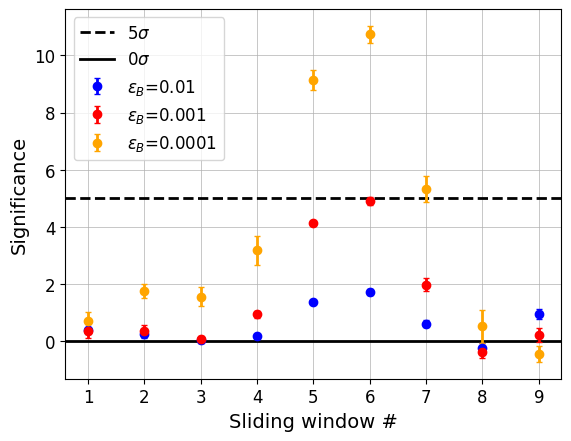

In [49]:
folder = general_directory+"cathode_norm_weights/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=cathode_weights_error)
plotting(rel_results, true_results, "cathode_norm_weights")

We get slightly higher significance than without doctor. Note that improvements should be larger still, since here the weights are obtained using the DE's training data. Need to train a DE with slightly less training data to have unused data left over for weights.

Reminder: results without doctor

![image](plots/cathode_norm.png) 